In [1]:
import sys
sys.path.append('../')
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Dimensionality vs. encoding performance

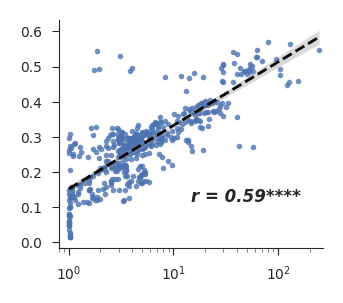

In [2]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.4))

ax.set_xlim(0.8, 270)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel=None, ylabel=None, xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.5, 0.2), ax=ax)

plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()